In [1]:
import time
import sys
import pathlib
import os
import numpy as np
import cv2 as cv
from spatialmath import SE3
from scipy.spatial.transform import Rotation as R
import matplotlib.pyplot as plt
from spatialmath.base import trotx, troty, trotz
import roboticstoolbox as rtb
# Fix for notebooks: add the parent directory to sys.path
notebook_path = os.getcwd()
sys.path.append(str(pathlib.Path(notebook_path).parent))

# Now import your custom robot class
from classrobot.UR5e_DH import UR5eDH
import roboticstoolbox as rtb
from classrobot.robot_movement import RobotControl


In [2]:
def cubic_trajectoy_planning(p0, p1, v0, v1, T, dt):
    """
    Compute a cubic polynomial trajectory for a single coordinate.
    
    The polynomial is:
        p(t) = a*t^3 + b*t^2 + v0*t + p0
    with coefficients:
        a = [2*(p0 - p1) + (v0 + v1)*T] / T^3
        b = [3*(p1 - p0) - (2*v0 + v1)*T] / T^2

    Returns:
        t   : Time vector.
        pos : Joint position along the trajectory.
        vel : Joint velocity along the trajectory.
        acc : Joint acceleration along the trajectory.
    """
    t = np.arange(0, T + dt, dt)
    a = (2 * (p0 - p1) + (v0 + v1) * T) / (T**3)
    b = (3 * (p1 - p0) - (2 * v0 + v1) * T) / (T**2)
    pos = a * t**3 + b * t**2 + v0 * t + p0      # Joint position
    vel = 3 * a * t**2 + 2 * b * t + v0            # Joint velocity
    return t, pos, vel


def compute_trajectory_time(d, v_tool, a_max):
    """
    Compute the total trajectory time based on the distance d, the desired tool speed v_tool, 
    and the maximum acceleration a_max. It chooses between a triangular or trapezoidal velocity profile.

    Parameters:
        d      : Distance between start and goal [m]
        v_tool : Desired tool speed [m/s]
        a_max  : Maximum allowable acceleration [m/s^2]

    Returns:
        T_total : Total trajectory time [s]
        profile : String indicating which profile is used ('Triangular' or 'Trapezoidal')
    """
    # Check if the move is too short to reach the desired speed:
    if d < (v_tool ** 2) / a_max:
        # Triangular profile: cannot reach v_tool, so we peak at a lower velocity.
        T_total = 2 * np.sqrt(d / a_max)
        profile = 'Triangular'
    else:
        # Trapezoidal profile: we accelerate to v_tool, cruise, and then decelerate.
        T_accel = v_tool / a_max  # Time to accelerate to v_tool
        d_accel = 0.5 * a_max * T_accel**2  # Distance covered during acceleration
        # Since deceleration distance is the same, total distance on ramps:
        d_ramps = 2 * d_accel
        T_total = 2 * T_accel + (d - d_ramps) / v_tool
        profile = 'Trapezoidal'
    return T_total, profile


def pose_to_fk_matrix(pose):
    """
    Convert a 6-element pose into a 4x4 homogeneous transformation matrix.
    
    Parameters:
        pose: A list or array with 6 elements [x, y, z, roll, pitch, yaw].
              - [x, y, z]  : Translation components.
              - [roll, pitch, yaw] : Rotations in radians (assumed ZYX order).
    
    Returns:
        T: 4x4 numpy array representing the transformation matrix.
    """
    tx, ty, tz, roll, pitch, yaw = pose

    # Rotation about Z-axis (yaw)
    Rz = np.array([[np.cos(yaw), -np.sin(yaw), 0],
                   [np.sin(yaw),  np.cos(yaw), 0],
                   [0,            0,           1]])
    
    # Rotation about Y-axis (pitch)
    Ry = np.array([[np.cos(pitch),  0, np.sin(pitch)],
                   [0,              1, 0],
                   [-np.sin(pitch), 0, np.cos(pitch)]])
    
    # Rotation about X-axis (roll)
    Rx = np.array([[1, 0,           0],
                   [0, np.cos(roll), -np.sin(roll)],
                   [0, np.sin(roll),  np.cos(roll)]])
    
    # Compose rotations in ZYX order: first yaw, then pitch, then roll.
    R = Rz @ Ry @ Rx  # using the @ operator for matrix multiplication
    
    # Build the homogeneous transformation matrix
    T = np.eye(4)
    T[:3, :3] = R
    T[:3, 3] = [tx, ty, tz]
    
    return T

In [3]:
robot_ip = "192.168.200.10"

# Robot DH parameters
# Robot DH parameters
robotDH = UR5eDH()
tool_offset = SE3(0, 0, 0.200)
robotDH.tool = tool_offset
print(robotDH)
T_world = SE3(0, 0.4, -0.115) * SE3.Rx(np.deg2rad(90)) * SE3.Ry(0) * SE3.Rz(0)
T_inv = T_world.inv()

# Set the robot's base transformation:
robotDH.base = T_inv

# Robot UR5e connection
real_robot = RobotControl()
real_robot.robot_release()
real_robot.robot_init(robot_ip)


DHRobot: UR5e (by Universal Robotics), 6 joints (RRRRRR), dynamics, standard DH parameters
┌─────┬────────┬─────────┬────────┐
│ θⱼ  │   dⱼ   │   aⱼ    │   ⍺ⱼ   │
├─────┼────────┼─────────┼────────┤
│  q1 │ 0.1625 │       0 │  90.0° │
│  q2 │      0 │  -0.425 │   0.0° │
│  q3 │      0 │ -0.3922 │   0.0° │
│  q4 │ 0.1333 │       0 │  90.0° │
│  q5 │ 0.0997 │       0 │ -90.0° │
│  q6 │ 0.0996 │       0 │   0.0° │
└─────┴────────┴─────────┴────────┘

┌──────┬─────────────────────────────────────┐
│ tool │ t = 0, 0, 0.2; rpy/xyz = 0°, 0°, 0° │
└──────┴─────────────────────────────────────┘

┌────────┬────────┬───────┬───────┬───────┬────────┬───────┐
│   name │ q0     │ q1    │ q2    │ q3    │ q4     │ q5    │
├────────┼────────┼───────┼───────┼───────┼────────┼───────┤
│     qr │  180°  │  0°   │  0°   │  0°   │  90°   │  0°   │
│     qz │  0°    │  0°   │  0°   │  0°   │  0°    │  0°   │
│ q_HOME │  41.6° │ -111° │ -117° │ -130° │ -50.6° │  136° │
└────────┴────────┴───────┴───────┴─────

In [4]:
pos_home = [0.7011797304915488, 0.18427154391614353, 0.17217411213036665,
            -1.7318443587261685, 0.686842056802218, -1.7312759524010408]
pos_right_bottom = [0.7011797304915488, 0.18427154391614353-0.1, -0.43708867396716417,
                    -1.7320526609998639, 0.6867495616307455, -1.7312152841633146]

# --- 1. Get the current TCP pose ---
pos_current = real_robot.robot_get_position()
T_current = SE3(pos_current[0], pos_current[1], pos_current[2]) @ SE3.RPY(pos_current[3], pos_current[4], pos_current[5], unit='rad')
# print("Current TCP Pose:\n", T_current)
# --- 3. Build SE3 objects from the TCP pose vectors ---
# Here we assume the ordering: [x, y, z, roll, pitch, yaw]
T_Home = SE3(pos_home[0], pos_home[1], pos_home[2]) @ SE3.RPY(pos_home[3], pos_home[4], pos_home[5], unit='rad')
T_end   = SE3(pos_right_bottom[0], pos_right_bottom[1], pos_right_bottom[2]) @ SE3.RPY(pos_right_bottom[3], pos_right_bottom[4], pos_right_bottom[5], unit='rad')

print("Start TCP Pose:\n", T_current)
print("Target TCP Pose:\n", T_end)


Start TCP Pose:
   -0.1319   -0.05604   0.9897    0.7       
  -0.7509    0.6575   -0.06284   0.18      
  -0.6472   -0.7514   -0.1288    0.17      
   0         0         0         1         

Target TCP Pose:
   -0.1235   -0.05854   0.9906    0.7012    
  -0.7634    0.6434   -0.05717   0.08427   
  -0.634    -0.7633   -0.1242   -0.4371    
   0         0         0         1         



In [5]:
# --- 4. Generate a Cartesian trajectory between the two TCP poses ---

# Zero initial and final Cartesian velocities (for a smooth start/stop)
v0_cart = 0.0
v1_cart = 0.0

# Extract the translation from T_start and T_end
pos_start = T_current.t  # This is a (3,) numpy array [x, y, z]
pos_end   = T_end.t
print("Start position:", pos_start)
print("End position:", pos_end)
# cal distance between start and end position
dist = np.linalg.norm(pos_end - pos_start)
print("Distance between start and end position:", dist)
# Define the total trajectory duration (seconds)
v_tool = 0.1     # Desired tool speed in m/s
a_max = 1.2     # Maximum acceleration in m/s^2
T_total, profile = compute_trajectory_time(dist, v_tool, a_max)
print("Selected Profile:", profile)
print("Total Trajectory Time: {:.3f} seconds".format(T_total))
dt = 1/100      # Control loop time step
# Time vector for the trajectory
t_vec = np.arange(0, T_total + dt, dt)

# Generate the translational (x, y, z) trajectory using cubic interpolation.
pos_traj = np.zeros((len(t_vec), 3))
speed_traj = np.zeros((len(t_vec), 3))  # Initialize speed trajectory array


for i in range(3):
    time, pos_traj[:, i], speed_i = cubic_trajectoy_planning(pos_start[i], pos_end[i],
                                                    v0_cart, v1_cart,
                                                    T_total, dt)
    speed_traj[:, i] = speed_i
    # print(f"pos_traj[:, {i}]: {pos_traj[:, i]}")
    # print(f"speed[:, {i}]: {speed}")
    # print(f"acc[:, {i}]: {acc}")

# Check the endpoints for speed (should be 0)
print("Speed at start (x-axis):", speed_traj[0, 0])
print("Speed at end (x-axis):", speed_traj[-1, 0])
print("Number of trajectory points:", len(pos_traj))


# how many points in the trajectory?
print("Number of points in the trajectory:", len(pos_traj))

# For the orientation, interpolate using the SE3.interp method.
traj_T = []
for j, t in enumerate(t_vec):
    s = t / T_total  # normalized time [0, 1]
    # Interpolate the full SE3 pose
    T_interp = T_current.interp(T_Home, s)
    # Replace the translation with the cubic trajectory value for consistency
    T_interp = SE3.Rt(T_interp.R[:3, :3], pos_traj[j, :])  # Ensure R is a 3x3 rotation matrix
    traj_T.append(T_interp)

print("Interpolated TCP poses:")
# for T in traj_T:
#     print(T)
waypoints = []
for T in traj_T:
    # เก็บ SE3 pose ตรง ๆ เข้า waypoints
    waypoints.append(T)

print("Total Waypoint:", len(waypoints))
print(waypoints[-1])


Start position: [0.69999547 0.17997078 0.16997976]
End position: [ 0.70117973  0.08427154 -0.43708867]
Distance between start and end position: 0.6145663735809207
Selected Profile: Trapezoidal
Total Trajectory Time: 6.229 seconds
Speed at start (x-axis): 0.0
Speed at end (x-axis): -1.8369685401086432e-07
Number of trajectory points: 624
Number of points in the trajectory: 624
Interpolated TCP poses:
Total Waypoint: 624
  -0.1236   -0.05828   0.9906    0.7012    
  -0.7633    0.6435   -0.05735   0.08427   
  -0.6341   -0.7632   -0.124    -0.4371    
   0         0         0         1         



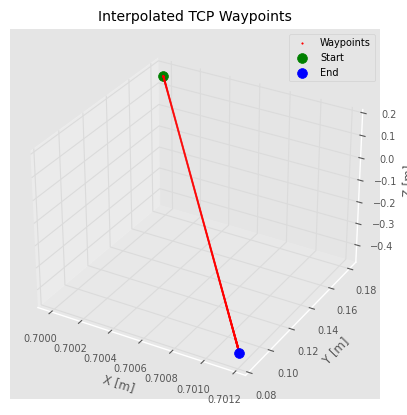

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # Required for 3D plotting

# Create an array of translations from the waypoints:
positions = np.array([T.t for T in waypoints])  # Shape: (n_points, 3)

# Now let's plot them:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the trajectory line connecting the waypoints
ax.scatter(positions[:, 0], positions[:, 1], positions[:, 2], color='red', label="Waypoints", s=1)

# Optionally, add markers for the start and end positions
ax.scatter(pos_start[0], pos_start[1], pos_start[2], color='green', s=50, label="Start")
ax.scatter(pos_end[0], pos_end[1], pos_end[2], color='blue', s=50, label="End")

ax.set_xlabel('X [m]')
ax.set_ylabel('Y [m]')
ax.set_zlabel('Z [m]')
ax.set_title('Interpolated TCP Waypoints')
ax.legend()
plt.show()


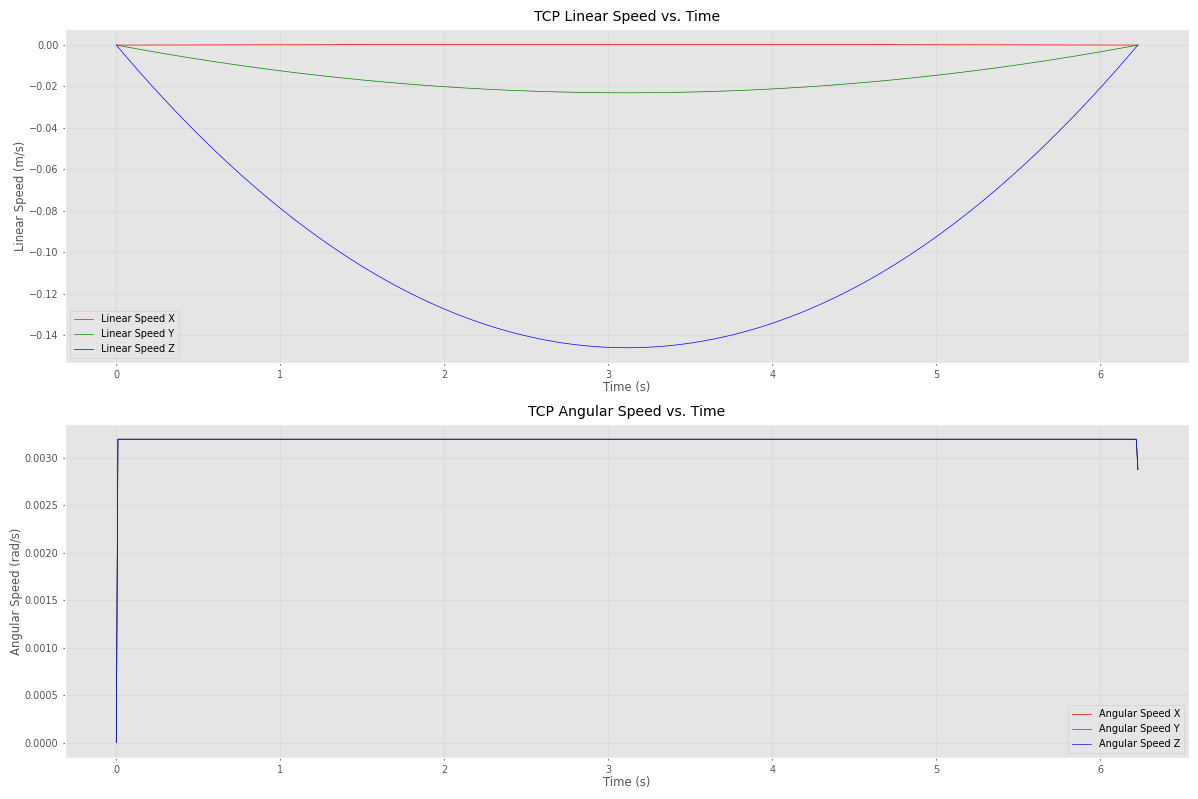

In [9]:
import numpy as np

import matplotlib.pyplot as plt

# Calculate angular speeds from SE3 poses
angular_speeds = np.zeros((len(traj_T), 3))  # Initialize array for angular speeds
for i in range(1, len(traj_T)):
    # Compute the relative transformation between consecutive poses
    delta_T = traj_T[i - 1].inv() * traj_T[i]
    # Extract the angular velocity (rotation vector) from the relative transformation
    angular_speeds[i, :] = delta_T.angvec()[0] / dt  # Divide by dt to get angular speed

# Create a figure with a specified size
plt.figure(figsize=(12, 8))

# Plot linear speeds
plt.subplot(2, 1, 1)
plt.plot(t_vec, speed_traj[:, 0], 'r-', label='Linear Speed X')  # Red line for X axis speed
plt.plot(t_vec, speed_traj[:, 1], 'g-', label='Linear Speed Y')  # Green line for Y axis speed
plt.plot(t_vec, speed_traj[:, 2], 'b-', label='Linear Speed Z')  # Blue line for Z axis speed
plt.xlabel("Time (s)")
plt.ylabel("Linear Speed (m/s)")
plt.title("TCP Linear Speed vs. Time")
plt.legend()
plt.grid(True)

# Plot angular speeds
plt.subplot(2, 1, 2)
plt.plot(t_vec, angular_speeds[:, 0], 'r-', label='Angular Speed X')  # Red line for X axis angular speed
plt.plot(t_vec, angular_speeds[:, 1], 'g-', label='Angular Speed Y')  # Green line for Y axis angular speed
plt.plot(t_vec, angular_speeds[:, 2], 'b-', label='Angular Speed Z')  # Blue line for Z axis angular speed
plt.xlabel("Time (s)")
plt.ylabel("Angular Speed (rad/s)")
plt.title("TCP Angular Speed vs. Time")
plt.legend()
plt.grid(True)

# Display the plots
plt.tight_layout()
plt.show()


In [ ]:

# for T_target in waypoints:
#     pos = T_target.t        # [x, y, z]
#     rpy = T_target.rpy()    # [roll, pitch, yaw] rad

#     # concat เป็น [x, y, z, rx, ry, rz] (rx,ry,rz=axis-angle)
#     pose = np.concatenate((pos, rpy))
#     real_robot.robot_move_jik(pose, speed=0.1, acceleration=1.2)


dq[1]: [ 1.64385603e-03  1.73021360e-03 -2.37551244e-03  6.64193843e-04
  1.64370030e-03 -2.94786676e-05]
dq[2]: [ 3.28209741e-03  3.45501037e-03 -4.74369495e-03  1.32657992e-03
  3.28178355e-03 -5.91282870e-05]
dq[3]: [ 4.91534260e-03  5.17388899e-03 -7.10394541e-03  1.98704378e-03
  4.91486881e-03 -8.89098901e-05]
dq[4]: [ 0.00654331  0.0068875  -0.00945656  0.00264441  0.00654269 -0.00011755]
dq[5]: [ 0.00816601  0.00859506 -0.01180164  0.0033008   0.00816523 -0.00014699]
dq[6]: [ 0.00978347  0.01029779 -0.01413872  0.00395344  0.00978254 -0.00017553]
dq[7]: [ 0.01139497  0.01199504 -0.01646873  0.00460437  0.01139389 -0.00020389]
dq[8]: [ 0.01300248  0.01368629 -0.01879057  0.00525362  0.01300125 -0.00023299]
dq[9]: [ 0.01460439  0.01537151 -0.02110474  0.00590109  0.014603   -0.00026189]
dq[10]: [ 0.01619881  0.01705204 -0.02341281  0.00654728  0.01619727 -0.000291  ]
dq[11]: [ 0.01779019  0.01872645 -0.02571172  0.00719033  0.0177885  -0.00031996]
dq[12]: [ 0.01937631  0.02039589

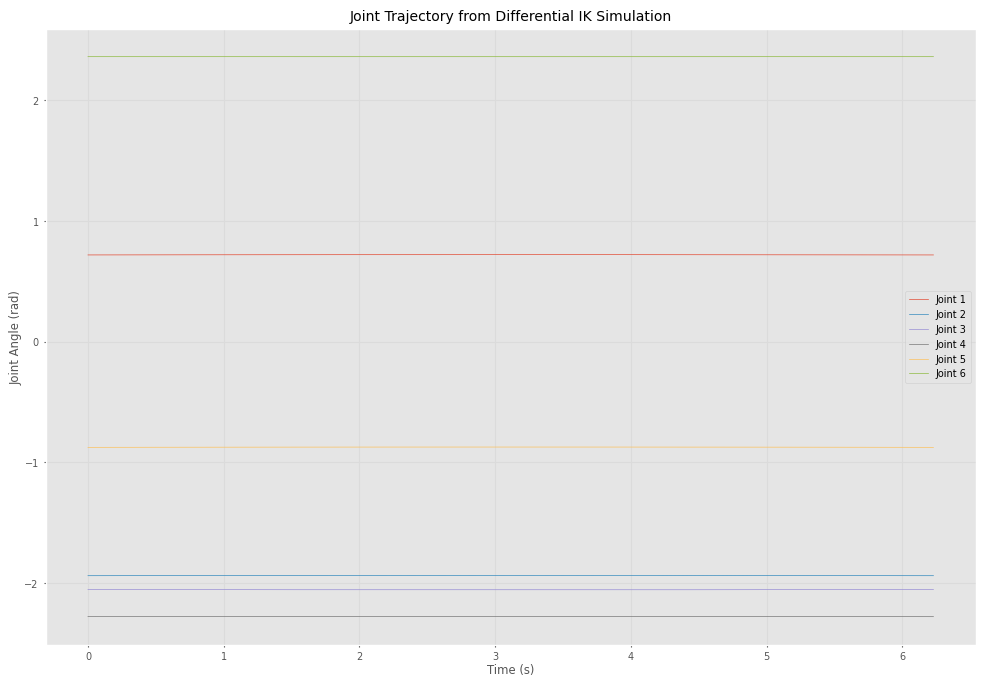

In [8]:
import numpy as np
import time
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation

# Assume that t_vec, traj_T, speed_traj, dt, robotDH, real_robot, SE3 are defined.

# Log container for joint configurations:
q_history = []

# Initialize joint configuration from real robot (or using an IK solution for the start pose)
q_current = real_robot.robot_get_joint_rad()  # current joint configuration (in radians)
q_history.append(q_current.copy())

# Differential IK Control Loop (simulation mode - speedJ command is commented out)
for j in range(1, len(t_vec)):
    # Get the desired TCP pose for the current time step (for feedback, if used)
    T_desired = traj_T[j]
    
    # 1. Get the current TCP pose from the real robot.
    T_val = real_robot.robot_get_fk()
    T_current_val = SE3(T_val[0], T_val[1], T_val[2]) @ \
                    SE3.RPY(T_val[3], T_val[4], T_val[5], unit='rad')
    
    # 2. Get the current joint configuration from the robot.
    q_current = real_robot.robot_get_joint_rad()
    
    # 3. Define the desired Cartesian velocity using the precomputed speed.
    #    Here, we use the linear speeds from speed_traj for the current time step.
    v_linear = speed_traj[j, :]  # a 3-element array [vx, vy, vz] at time step j
    # For pure linear movement without rotation, set angular velocity to zero:
    v_angular = np.zeros(3)
    # Combine into a 6D velocity command:
    v_desired = np.concatenate((v_linear, v_angular))  # [vx, vy, vz, wx, wy, wz]
    
    # (Optional: you can add a feedback term by computing error twist and adding it, if needed.)
    
    # 4. Compute the body Jacobian at the current joint configuration.
    J = robotDH.jacobe(q_current)
    
    if v_desired.shape[0] != 6:
        raise ValueError("v_desired must be 6-dimensional")
    if J.shape[0] != 6:
        raise ValueError("Jacobian must have 6 rows")
    
    # 5. Map the desired TCP velocity to joint velocities using the pseudoinverse of the Jacobian.
    dq = np.linalg.pinv(J) @ v_desired
    
    # Debug print: Show computed joint velocity command.
    print(f"dq[{j}]:", dq)
    
    # 6. Instead of sending the command with speedJ, we simply log the joint data.
    # real_robot.robot_speed_J(dq.tolist(), acceleration=0.5, time=dt)  # Commented out for simulation
    
    # 7. Update the joint configuration using Euler integration (simulate the effect).
    q_next = q_current + dq * dt
    q_history.append(q_next.copy())
    
    # Update current joint configuration for simulation purposes.
    q_current = q_next.copy()
    
    # 8. Wait for the control loop duration
    time.sleep(dt)

# Convert the log of joint configurations to a NumPy array.
q_traj = np.array(q_history)

# ----- Plotting the Joint Trajectory -----
# Assuming q_traj is of shape (num_points, n_joints)
num_points = q_traj.shape[0]
n_joints = q_traj.shape[1]
time_axis = np.linspace(0, dt * (num_points-1), num_points)

plt.figure(figsize=(12, 8))
for i in range(n_joints):
    plt.plot(time_axis, q_traj[:, i], label=f'Joint {i+1}')
plt.xlabel("Time (s)")
plt.ylabel("Joint Angle (rad)")
plt.title("Joint Trajectory from Differential IK Simulation")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
import time
# For differential IK control loop using speedJ:
q_history = []

# Initialize joint configuration (can use an IK solution or current joint reading):
q_current = real_robot.robot_get_joint_rad()  # current joint configuration in radians
q_history.append(q_current.copy())

for j in range(1, len(t_vec)):
    # Optionally, get the desired TCP pose for feedback (T_desired)
    T_desired = traj_T[j]
    
    # 1. Get the current TCP pose from the real robot.
    T_val = real_robot.robot_get_fk()
    T_current_val = SE3(T_val[0], T_val[1], T_val[2]) @ SE3.RPY(T_val[3], T_val[4], T_val[5], unit='rad')
    
    # 2. Get the current joint configuration from the robot.
    q_current = real_robot.robot_get_joint_rad()
    
    # 3. Define the desired Cartesian velocity using the precomputed speed.
    # Here, we use the linear speeds from speed_traj for the current timestep.
    v_linear = speed_traj[j, :]  # a 3-element array [vx, vy, vz] at time step j
    # For pure linear movement without rotation, set angular velocity to zero:
    v_angular = np.zeros(3)
    
    # Combine into a 6D velocity command:
    v_desired = np.concatenate((v_linear, v_angular))  # [vx, vy, vz, wx, wy, wz]
    
    # (Optional: if you desire feedback correction,
    # you could compute the error twist between T_current and T_desired and add a feedback term.)
    
    # 4. Compute the body Jacobian (jacobe) at the current joint configuration.
    J = robotDH.jacobe(T_val)
    
    if v_desired.shape[0] != 6:
        raise ValueError("v_desired must be 6-dimensional")
    if J.shape[0] != 6:
        raise ValueError("Jacobian must have 6 rows")
    
    # 5. Map the desired TCP velocity to joint velocities.
    dq = np.linalg.pinv(J) @ v_desired
    
    # Debug print:
    print(f"dq[{j}]:", dq)
    
    # 6. Send the joint velocity command to the real robot using speedJ.
    real_robot.robot_speed_J(dq.tolist(), acceleration=0.5, time=dt)
    
    # 7. Log the current joint configuration.
    q_history.append(q_current.copy())
    
    # 8. Wait for the control loop duration to maintain real-time control.
    time.sleep(dt)

# After the loop, convert joint history to an array.
q_traj = np.array(q_history)

dq[1]: [-0.00018521 -0.00807417  0.01933539 -0.00787114  0.00329363  0.00040666]


IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [ ]:
# --- 6. Visualization ---
# Plot joint trajectories
plt.figure(figsize=(10, 6))
for i in range(robotDH.n):
    plt.plot(t_vec, q_traj[:, i], label=f'Joint {i+1}')
plt.xlabel('Time (s)')
plt.ylabel('Joint Angle (rad)')
plt.title('Joint Trajectories via Differential IK (Cartesian TCP Control)')
plt.legend()
plt.grid(True)
plt.show()

# Animate the robot following the computed joint trajectory.
# robotDH.plot(q_traj, dt=dt)



In [ ]:
# T_current = real_robot.robot_get_fk()
# T_current = SE3(T_current[0], T_current[1], T_current[2]) @ SE3.RPY(T_current[3], T_current[4], T_current[5], unit='rad')
# J = robotDH.jacobe(q_current)

# Main loop: at each time step, compute a joint update from the Cartesian error.
# for j in range(1, len(t_vec)):
#     T_desired = traj_T[j]

#     # Compute the current TCP pose from forward kinematics.
#     # T_current = robot.fkine(q_current)
#     T_current = real_robot.robot_get_fk()
#     T_current = SE3(T_current[0], T_current[1], T_current[2]) @ SE3.RPY(T_current[3], T_current[4], T_current[5], unit='rad')
#     # Compute the error twist using the logarithm map, which gives a 6D error (rotation + translation)
#     error_twist = (T_current.inv() * T_desired).log(twist=True)

#     # Compute the Jacobian at the current configuration.
#     J = robotDH.jacobe(q_current)
#     # Map the 6D Cartesian error to joint velocity commands via pseudo-inverse.
#     # Ensure error_twist is a 6-element vector
#     if error_twist.shape[0] != 6:
#         raise ValueError(f"Expected error_twist to have 6 elements, but got {error_twist.shape[0]}")

#     # Ensure J has 6 rows
#     if J.shape[0] != 6:
#         raise ValueError(f"Expected Jacobian J to have 6 rows, but got {J.shape[0]}")

#     # Compute joint velocity commands
#     dq = np.linalg.pinv(J) @ error_twist

    
#     # Update the joint configuration using Euler integration.
#     q_current = q_current + dq * dt
#     q_history.append(q_current.copy())

#     time.sleep(dt)  # Optional: simulate real-time control timing


# q_traj = np.array(q_history)


# direction = pos_end - pos_start
# direction = direction / np.linalg.norm(direction)  # Normalize to get unit vector
# fixed_speed = 0.1  # m/s
# v_linear = fixed_speed * direction  # Fixed linear velocity along desired direction

# # No angular velocity for pure linear motion.
# v_angular = np.zeros(3)

# # Desired TCP velocity: [vx, vy, vz, wx, wy, wz]
# v_desired = np.concatenate((v_linear, v_angular))
# print("Desired TCP velocity:", v_desired)